In [ ]:
!pip install groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.6/129.6 kB 5.5 MB/s eta 0:00:00


In [ ]:
!pip install -q nlpaug

In [ ]:
!pip install -q transformers datasets evaluate accelerate

In [ ]:
!pip install "numpy<2.0"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 87.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [ ]:
# Install required packages
!pip install -q transformers datasets evaluate accelerate
!pip install -q nlpaug
!pip install -q openai  # Untuk AI labeling (opsional)

import tensorflow as tf
import pandas as pd
import numpy as np
import json
import ast
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

print("TensorFlow version:", tf.__version__)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 114.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 14.9 MB/s eta 0:00:00
TensorFlow version: 2.18.0


In [ ]:
from groq import Groq

In [ ]:
# Configure Kaggle API & download dataset
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d pandupt/ocr-dataset-indonesia -p /content/ocr_indonesia --unzip

Dataset URL: https://www.kaggle.com/datasets/pandupt/ocr-dataset-indonesia
License(s): apache-2.0
 99% 463M/468M [00:07<00:00, 70.0MB/s]
100% 468M/468M [00:07<00:00, 66.6MB/s]


# Data Extraction

In [ ]:
# Parse HF-style JSONL to DataFrame df_items
ann_path = "/content/ocr_indonesia/data/annotations/huggingface_train.jsonl"
rows = []
with open(ann_path, "r", encoding="utf-8") as f:
    for line in f:
        rec   = json.loads(line)
        rid   = rec["id"]
        outer = json.loads(rec["parsed_data"])
        s     = outer["json"]
        if s.startswith('"') and s.endswith('"'):
            s = s[1:-1]
        s = s.encode("utf-8").decode("unicode_escape")
        try:
            inner = ast.literal_eval(s)
        except:
            continue
        for li in inner.get("line_items", []):
            if isinstance(li, dict):
                item   = li.get("item_name","").strip()
                amount = li.get("item_value","").replace(".","").replace(",","")
                if item and amount.isdigit():
                    rows.append({
                        "receipt_id": rid,
                        "item":       item,
                        "amount":     int(amount)
                    })

df_items = pd.DataFrame(rows)
print(f"Extracted {len(df_items)} line‐items")

Extracted 7038 line‐items


# Improved Labeling (Keywords + AI API)

In [ ]:
# Extended keywords untuk labeling yang lebih baik
extended_keywords = {
    'makanan': [
        # Makanan Indonesia
        'nasi', 'ayam', 'mie', 'roti', 'sate', 'ikan', 'bakso', 'tahu', 'tempe',
        'soto', 'rendang', 'lumpia', 'risol', 'bubur', 'kwetiau', 'udang', 'cumi',
        'bebek', 'siomay', 'bihun', 'telur', 'telor', 'tlr', 'tlur', 'bakar',
        'goreng', 'gado', 'pecel', 'rawon', 'opor', 'gulai', 'sambal', 'lalapan',
        'nila', 'gurame', 'lele', 'bawal', 'kakap', 'tongkol', 'bandeng', 'patin',
        'martabak', 'ketoprak', 'batagor', 'pempek', 'tekwan', 'otak-otak',

        # Makanan Internasional
        'burger', 'pizza', 'pasta', 'spaghetti', 'sushi', 'ramen', 'udon',
        'beef', 'chicken', 'wagyu', 'bacon', 'karaage', 'katsu', 'steak',
        'sandwich', 'salad', 'soup', 'rice', 'fried', 'grilled', 'roasted',

        # Snack & Dessert
        'kue', 'cake', 'donat', 'donut', 'croissant', 'pie', 'brownie', 'cookies',
        'pastry', 'bakpia', 'kacang', 'keripik', 'chips', 'coklat', 'chocolate',
        'es krim', 'ice cream', 'pudding', 'jelly', 'wafer', 'biskuit',

        # Variasi penulisan
        'chkn', 'ckn', 'aym', 'nsi', 'gkg', 'grg', 'bkr', 'sty', 'ste',
        'mball', 'bso', 'udg', 'cm', 'ikn', 'ns', 'mi'
    ],

    'minuman': [
        # Minuman umum
        'air', 'aqua', 'teh', 'kopi', 'jus', 'juice', 'soda', 'es', 'ice',
        'mineral', 'water', 'drink', 'beverage',

        # Kopi
        'coffee', 'latte', 'cappuccino', 'espresso', 'americano', 'mocha',
        'macchiato', 'frappuccino', 'cold brew', 'v60', 'kopi susu',

        # Teh & variasi
        'tea', 'ocha', 'matcha', 'thai tea', 'milk tea', 'bubble', 'boba',
        'tarik', 'manis', 'lemon tea', 'fruit tea',

        # Soft drinks
        'cola', 'coke', 'pepsi', 'fanta', 'sprite', 'pocari', 'gatorade',
        'isotonic', 'energy drink', 'redbull',

        # Others
        'milkshake', 'smoothie', 'yogurt', 'yakult', 'susu', 'milk',
        'beer', 'bir', 'wine'
    ],

    'atk': [
        'pulpen', 'pen', 'pensil', 'pencil', 'notebook', 'book', 'buku',
        'kertas', 'paper', 'stapler', 'staples', 'penghapus', 'eraser',
        'spidol', 'marker', 'map', 'folder', 'file', 'clip', 'paperclip',
        'gunting', 'scissors', 'lem', 'glue', 'tape', 'selotip', 'ruler',
        'penggaris', 'correction', 'tipex', 'highlighter', 'stabilo',
        'post-it', 'sticky note', 'envelope', 'amplop'
    ],

    'transport': [
        'ojek', 'ojol', 'taksi', 'taxi', 'cab', 'bus', 'kereta', 'train',
        'grab', 'gojek', 'go-jek', 'uber', 'parking', 'parkir', 'toll',
        'tol', 'tiket', 'ticket', 'fare', 'transport', 'transportation',
        'charge', 'fee', 'bensin', 'fuel', 'gas', 'pertamax', 'premium',
        'mrt', 'lrt', 'krl', 'commuter', 'angkot', 'mikrolet'
    ],

    'hiburan': [
        'bioskop', 'cinema', 'movie', 'film', 'netflix', 'spotify', 'game',
        'gaming', 'konser', 'concert', 'musik', 'music', 'karaoke', 'ktv',
        'teater', 'theater', 'museum', 'tiket', 'ticket', 'show', 'live',
        'streaming', 'subscription', 'membership', 'youtube', 'disney',
        'hbo', 'viu', 'wetv', 'iqiyi'
    ],

    'kesehatan': [
        'apotik', 'apotek', 'pharmacy', 'obat', 'medicine', 'drug', 'vitamin',
        'supplement', 'dokter', 'doctor', 'clinic', 'klinik', 'rs', 'rumah sakit',
        'hospital', 'medical', 'medis', 'tablet', 'kapsul', 'capsule', 'sirup',
        'syrup', 'salep', 'ointment', 'plester', 'bandage', 'masker', 'mask',
        'hand sanitizer', 'antiseptic', 'bpjs', 'lab', 'laboratory', 'test',
        'check up', 'checkup', 'konsultasi', 'consultation'
    ],

    'elektronik': [
        'hp', 'handphone', 'phone', 'smartphone', 'laptop', 'computer', 'pc',
        'tablet', 'ipad', 'charger', 'cable', 'kabel', 'earphone', 'headphone',
        'headset', 'speaker', 'mouse', 'keyboard', 'monitor', 'printer',
        'scanner', 'usb', 'memory', 'hardisk', 'ssd', 'ram', 'processor',
        'battery', 'baterai', 'powerbank', 'adapter', 'hdmi', 'wifi', 'router'
    ],

    'fashion': [
        'baju', 'kaos', 'shirt', 'kemeja', 'celana', 'pants', 'trousers',
        'rok', 'skirt', 'dress', 'gaun', 'jacket', 'jaket', 'sweater', 'hoodie',
        'sepatu', 'shoes', 'sandal', 'slipper', 'tas', 'bag', 'backpack',
        'wallet', 'dompet', 'belt', 'ikat pinggang', 'hat', 'topi', 'cap',
        'scarf', 'syal', 'gloves', 'sarung tangan', 'socks', 'kaos kaki',
        'underwear', 'pakaian dalam', 'jeans', 'batik', 'kebaya'
    ]
}

def improved_auto_label(item: str) -> str:
    s = item.lower()
    # Hitung skor match untuk setiap kategori
    scores = {}
    for cat, kws in extended_keywords.items():
        score = sum(1 for kw in kws if kw in s)
        if score > 0:
            scores[cat] = score

    # Return kategori dengan skor tertinggi
    if scores:
        return max(scores, key=scores.get)
    return 'lain-lain'

# Apply improved labeling
labels_df = pd.DataFrame({'item': df_items['item'].unique()})
labels_df['category'] = labels_df['item'].apply(improved_auto_label)

print("Distribusi kategori setelah improved labeling:")
print(labels_df['category'].value_counts())

Distribusi kategori setelah improved labeling:
category
lain-lain     2868
makanan       1424
minuman       1044
kesehatan      115
elektronik      95
fashion         75
atk             72
transport       59
hiburan         11
Name: count, dtype: int64


In [ ]:
# Labeling (AI API)
'''
def ai_label_batch_groq(items: List[str], batch_size: int = 20) -> Dict[str, str]:
    client = Groq(api_key="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")  # Get free API key from console.groq.com
    labeled_items = {}

    categories = ['makanan', 'minuman', 'atk', 'transport', 'hiburan',
                  'kesehatan', 'elektronik', 'fashion', 'lain-lain']

    for i in range(0, len(items), batch_size):
        batch = items[i:i+batch_size]

        #prompt = f'''#Klasifikasikan item receipt Indonesia ke kategori:
        #Kategori: {', '.join(categories)}

        #Items:
        #{chr(10).join(f"{j+1}. {item}" for j, item in enumerate(batch))}

        #Output format: item -> kategori
        '''

        try:
            response = client.chat.completions.create(
                model="meta-llama/llama-guard-4-12b",  # atau "llama2-70b-4096"
                messages=[
                    {"role": "system", "content": "Klasifikasikan item receipt Indonesia."},
                    {"role": "user", "content": prompt}
                ],
                temperature=0.3,
                max_tokens=1000
            )

            result = response.choices[0].message.content
            lines = result.strip().split('\n')

            for line in lines:
                if '->' in line:
                    parts = line.split('->')
                    if len(parts) == 2:
                        item_part = parts[0].strip()
                        category = parts[1].strip().lower()
                        item_name = item_part.split('. ', 1)[-1] if '. ' in item_part else item_part
                        if category in categories:
                            labeled_items[item_name] = category

        except Exception as e:
            print(f"Error in batch {i//batch_size}: {e}")
            continue

    return labeled_items

# Ambil items yang masih 'lain-lain' untuk di-label ulang dengan AI
unlabeled_items = labels_df[labels_df['category'] == 'lain-lain']['item'].tolist()
if unlabeled_items:
    print(f"Re-labeling {len(unlabeled_items)} items dengan AI...")
    ai_labels = ai_label_batch_groq(unlabeled_items[:100])  # Groq (gratis)

    # Update labels
    for item, category in ai_labels.items():
      labels_df.loc[labels_df['item'] == item, 'category'] = category
'''

Re-labeling 2868 items dengan AI...


In [ ]:
# Apply improved labeling
#labels_df = pd.DataFrame({'item': df_items['item'].unique()})
#labels_df['category'] = labels_df['item'].apply(improved_auto_label)

#print("Distribusi kategori setelah improved labeling:")
#print(labels_df['category'].value_counts())

Distribusi kategori setelah improved labeling:
category
lain-lain     2868
makanan       1424
minuman       1044
kesehatan      115
elektronik      95
fashion         75
atk             72
transport       59
hiburan         11
Name: count, dtype: int64


In [ ]:
# Save enhanced labels
labels_df.to_csv('qrep_labels_enhanced.csv', index=False)

# Text Augmentation

In [ ]:
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
from typing import List

class TextAugmenter:
    def __init__(self):
        # Character level augmenters
        self.char_augmenters = [
            nac.KeyboardAug(aug_char_max=2, aug_word_p=0.3),  # Typo keyboard
            nac.OcrAug(aug_char_max=2, aug_word_p=0.3),       # OCR errors
        ]

        # Word level augmenters
        self.word_augmenters = [
            naw.SpellingAug(dict_path='/content/ocr_indonesia/spelling_dict.txt',
                           aug_max=2) if os.path.exists('/content/ocr_indonesia/spelling_dict.txt') else None,
            naw.SynonymAug(aug_src='wordnet', lang='ind') if False else None,  # Need Indonesian wordnet
        ]

        # Filter out None augmenters
        self.word_augmenters = [aug for aug in self.word_augmenters if aug is not None]

    def augment_text(self, text: str, num_augment: int = 2) -> List[str]:
        """Generate augmented versions of text"""
        augmented_texts = [text]  # Include original

        # Character augmentation (OCR errors simulation)
        for aug in self.char_augmenters[:num_augment]:
            try:
                aug_text = aug.augment(text)
                if isinstance(aug_text, list):
                    augmented_texts.extend(aug_text[:1])
                else:
                    augmented_texts.append(aug_text)
            except:
                pass

        # Simple augmentations for Indonesian text
        # Lowercase/uppercase variations
        augmented_texts.append(text.lower())
        augmented_texts.append(text.upper())

        # Remove spaces (common in receipts)
        augmented_texts.append(text.replace(' ', ''))

        # Add common receipt abbreviations
        abbreviations = {
            'ayam': ['aym', 'chkn', 'chicken'],
            'goreng': ['grg', 'greng'],
            'nasi': ['ns', 'nsi'],
            'ikan': ['ikn'],
            'kopi': ['coffee', 'kpi'],
            'air': ['aqua', 'h2o']
        }

        words = text.lower().split()
        for word, abbrevs in abbreviations.items():
            if word in words:
                for abbrev in abbrevs[:1]:  # Use only first abbreviation
                    new_text = text.lower().replace(word, abbrev)
                    augmented_texts.append(new_text)

        # Remove duplicates and limit
        augmented_texts = list(set(augmented_texts))[:num_augment + 1]

        return augmented_texts

In [ ]:
# Test augmenter
augmenter = TextAugmenter()
sample_items = ["Nasi Goreng Ayam", "Es Teh Manis", "Kopi Susu"]
for item in sample_items:
    print(f"\nOriginal: {item}")
    print(f"Augmented: {augmenter.augment_text(item, num_augment=3)}")


Original: Nasi Goreng Ayam
Augmented: ['nasi goreng ayam', 'Nasi Cokeng Ayam', 'Nasi horenh Ayam', 'Nasi Goreng Ayam']

Original: Es Teh Manis
Augmented: ['es teh manis', 'EsTehManis', 'Es Teh han8s', 'ES TEH MANIS']

Original: Kopi Susu
Augmented: ['Kopi So8u', 'KOPI SUSU', 'Kopi SHs8', 'coffee susu']


# Prepare Augmented Dataset

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Merge and create augmented dataset
data = df_items.merge(labels_df, on="item")

# Create augmented training data
augmented_rows = []
for _, row in data.iterrows():
    # Original
    augmented_rows.append({
        'item': row['item'],
        'category': row['category'],
        'is_augmented': False
    })

    # Augmented versions (only for training)
    if row['category'] != 'lain-lain':  # Skip augmenting 'lain-lain'
        aug_texts = augmenter.augment_text(row['item'], num_augment=2)
        for aug_text in aug_texts[1:]:  # Skip original
            augmented_rows.append({
                'item': aug_text,
                'category': row['category'],
                'is_augmented': True
            })

augmented_df = pd.DataFrame(augmented_rows)
print(f"\nTotal data setelah augmentasi: {len(augmented_df)}")
print(f"Original: {len(augmented_df[~augmented_df['is_augmented']])}")
print(f"Augmented: {len(augmented_df[augmented_df['is_augmented']])}")

# Encode labels
le = LabelEncoder()

# Fit dan transform kategori
labels = np.array(["lain-lain",
                   "makanan",
                   "minuman",
                   "kesehatan",
                   "elektronik",
                   "fashion",
                   "atk",
                   "transport",
                   "hiburan"])

le.fit(labels)
augmented_df['label'] = le.transform(augmented_df['category'])

# Split with stratification
train_df, val_df = train_test_split(
    augmented_df[~augmented_df['is_augmented']],  # Only original for validation
    test_size=0.2,
    stratify=augmented_df[~augmented_df['is_augmented']]['label'],
    random_state=42
)


Total data setelah augmentasi: 14304
Original: 7038
Augmented: 7266


In [ ]:
# Add augmented data only to training
train_df = pd.concat([
    train_df,
    augmented_df[augmented_df['is_augmented']]
])

print(f"\nTrain size (with augmentation): {len(train_df)}")
print(f"Val size (original only): {len(val_df)}")


Train size (with augmentation): 12896
Val size (original only): 1408


# Modeling

In [ ]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import (
    TextVectorization, Embedding, Bidirectional, LSTM, GRU,
    Dense, Dropout, GlobalAveragePooling1D, LayerNormalization,
    Concatenate
)
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import tensorflow as tf

# Prepare data
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def df_to_dataset(dataframe, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((
        dataframe['item'].values,
        dataframe['label'].values
    ))
    if shuffle:
        ds = ds.shuffle(len(dataframe))
    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds

train_ds = df_to_dataset(train_df, shuffle=True)
val_ds = df_to_dataset(val_df, shuffle=False)

In [ ]:
# Text vectorization with larger vocabulary
max_vocab = 5000  # Increased from 2500
max_len = 20      # Increased from 16

vectorizer = TextVectorization(
    max_tokens=max_vocab,
    output_mode="int",
    output_sequence_length=max_len,
    standardize='lower_and_strip_punctuation'
)
vectorizer.adapt(train_ds.map(lambda text, label: text))

In [ ]:
# Build improved model with better regularization
def build_improved_model(num_classes, vocab_size=max_vocab):
    inputs = Input(shape=(1,), dtype=tf.string)

    # Vectorization
    x = vectorizer(inputs)

    # Embedding with regularization
    x = Embedding(
        input_dim=vocab_size,
        output_dim=64,  # Increased from 16
        mask_zero=True,
        embeddings_regularizer=tf.keras.regularizers.l2(1e-4)
    )(x)

    # Spatial Dropout (better for NLP)
    x = tf.keras.layers.SpatialDropout1D(0.3)(x)

    # Bidirectional LSTM with more units
    lstm_out = Bidirectional(
        LSTM(
            32,  # Increased from 8
            return_sequences=True,
            dropout=0.3,
            recurrent_dropout=0.2,
            kernel_regularizer=tf.keras.regularizers.l2(1e-4)
        )
    )(x)

    # Global pooling (better than just last output)
    avg_pool = GlobalAveragePooling1D()(lstm_out)
    max_pool = tf.keras.layers.GlobalMaxPooling1D()(lstm_out)

    # Concatenate pooling
    concat = Concatenate()([avg_pool, max_pool])

    # Layer normalization
    concat = LayerNormalization()(concat)

    # Dense layers with dropout
    x = Dense(
        64,
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(1e-4)
    )(concat)
    x = Dropout(0.4)(x)

    x = Dense(
        32,
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(1e-4)
    )(x)
    x = Dropout(0.3)(x)

    # Output layer
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)

    # Use AdamW optimizer (better for regularization)
    optimizer = AdamW(
        learning_rate=1e-3,
        weight_decay=1e-4
    )

    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
# Build and summarize model
num_classes = len(le.classes_)
model = build_improved_model(num_classes)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'global_max_pooling1d' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_vectorization  │ (None, 20)        │          0 │ input_layer[0][0] │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 20, 64)    │    320,000 │ text_vectorizati… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d   │ (None, 20, 64)    │          0 │ embedding[0][0]   │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 20)        │          0 │ text_vectorizati… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 20, 64)    │     24,832 │ spatial_dropout1… │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ bidirectional[0]… │
│ (GlobalAveragePool… │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ bidirectional[0]… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 128)       │        256 │ concatenate[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      8,256 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      2,080 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 9)         │        297 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 355,721 (1.36 MB)

 Trainable params: 355,721 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Enhanced callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,  # Increased patience
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    ),
    ModelCheckpoint(
        'best_model_improved.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

# Train with more epochs
epochs = 50  # Increased, early stopping will handle
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
403/403 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.3304 - loss: 1.7410
Epoch 1: val_loss improved from inf to 0.96760, saving model to best_model_improved.h5


403/403 ━━━━━━━━━━━━━━━━━━━━ 89s 180ms/step - accuracy: 0.3307 - loss: 1.7402 - val_accuracy: 0.7749 - val_loss: 0.9676 - learning_rate: 0.0010
Epoch 2/50
403/403 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.7276 - loss: 0.7987
Epoch 2: val_loss improved from 0.96760 to 0.73743, saving model to best_model_improved.h5


403/403 ━━━━━━━━━━━━━━━━━━━━ 70s 173ms/step - accuracy: 0.7276 - loss: 0.7986 - val_accuracy: 0.8288 - val_loss: 0.7374 - learning_rate: 0.0010
Epoch 3/50
403/403 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.7906 - loss: 0.5872
Epoch 3: val_loss improved from 0.73743 to 0.72319, saving model to best_model_improved.h5


403/403 ━━━━━━━━━━━━━━━━━━━━ 71s 177ms/step - accuracy: 0.7906 - loss: 0.5872 - val_accuracy: 0.8381 - val_loss: 0.7232 - learning_rate: 0.0010
Epoch 4/50
403/403 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.8188 - loss: 0.4971
Epoch 4: val_loss improved from 0.72319 to 0.69046, saving model to best_model_improved.h5


403/403 ━━━━━━━━━━━━━━━━━━━━ 80s 172ms/step - accuracy: 0.8188 - loss: 0.4971 - val_accuracy: 0.8516 - val_loss: 0.6905 - learning_rate: 0.0010
Epoch 5/50
403/403 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.8291 - loss: 0.4758
Epoch 5: val_loss did not improve from 0.69046
403/403 ━━━━━━━━━━━━━━━━━━━━ 83s 174ms/step - accuracy: 0.8291 - loss: 0.4758 - val_accuracy: 0.8501 - val_loss: 0.7173 - learning_rate: 0.0010
Epoch 6/50
403/403 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.8428 - loss: 0.4373
Epoch 6: val_loss did not improve from 0.69046
403/403 ━━━━━━━━━━━━━━━━━━━━ 70s 174ms/step - accuracy: 0.8428 - loss: 0.4373 - val_accuracy: 0.8572 - val_loss: 0.7367 - learning_rate: 0.0010
Epoch 7/50
403/403 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.8524 - loss: 0.4260
Epoch 7: val_loss improved from 0.69046 to 0.68897, saving model to best_model_improved.h5


403/403 ━━━━━━━━━━━━━━━━━━━━ 70s 174ms/step - accuracy: 0.8524 - loss: 0.4260 - val_accuracy: 0.8587 - val_loss: 0.6890 - learning_rate: 0.0010
Epoch 8/50
403/403 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.8397 - loss: 0.4338
Epoch 8: val_loss improved from 0.68897 to 0.68595, saving model to best_model_improved.h5


403/403 ━━━━━━━━━━━━━━━━━━━━ 69s 172ms/step - accuracy: 0.8397 - loss: 0.4338 - val_accuracy: 0.8558 - val_loss: 0.6860 - learning_rate: 0.0010
Epoch 9/50
403/403 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.8473 - loss: 0.4267
Epoch 9: val_loss did not improve from 0.68595
403/403 ━━━━━━━━━━━━━━━━━━━━ 86s 182ms/step - accuracy: 0.8473 - loss: 0.4267 - val_accuracy: 0.8608 - val_loss: 0.7122 - learning_rate: 0.0010
Epoch 10/50
403/403 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.8493 - loss: 0.4109
Epoch 10: val_loss did not improve from 0.68595
403/403 ━━━━━━━━━━━━━━━━━━━━ 70s 174ms/step - accuracy: 0.8493 - loss: 0.4109 - val_accuracy: 0.8523 - val_loss: 0.7075 - learning_rate: 0.0010
Epoch 11/50
403/403 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.8488 - loss: 0.4166
Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 11: val_loss did not improve from 0.68595
403/403 ━━━━━━━━━━━━━━━━━━━━ 88s 189ms/step - accuracy: 0.8488 - loss: 0.4166 - v

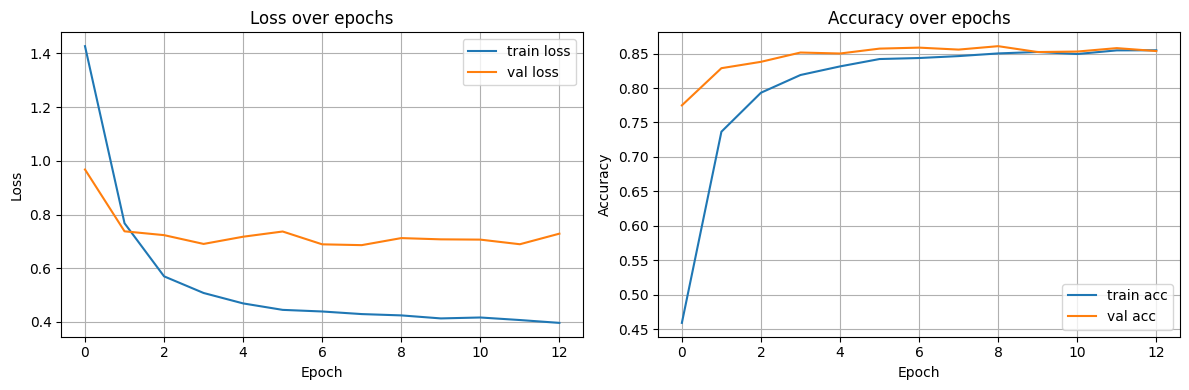

In [ ]:
# Plot results
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate
loss, acc = model.evaluate(val_ds)
print(f"\nFinal validation loss: {loss:.3f}")
print(f"Final validation accuracy: {acc:.3f}")

44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.8674 - loss: 0.6642

Final validation loss: 0.686
Final validation accuracy: 0.856


In [ ]:
# Test predictions
def predict_category(text):
    logits = model.predict(tf.constant([text]), verbose=0)
    idx = tf.argmax(logits[0]).numpy()
    confidence = tf.nn.softmax(logits[0])[idx].numpy()
    # le.inverse_transform untuk convert balik ke kategori
    category = le.inverse_transform([idx])[0]
    return category, confidence

test_items = [
    "Nasi Campur Bali",
    "AQUA 600ml",
    "Pulpen Pilot",
    "Go-Jek fee",
    "Spotify Premium",
    "Panadol Extra",
    "Charger iPhone",
    "Kaos Uniqlo"
]

print("\nTest predictions:")
for item in test_items:
    category, conf = predict_category(item)
    print(f"{item:20} → {category:12} (confidence: {conf:.2%})")


Test predictions:
Nasi Campur Bali     → makanan      (confidence: 25.36%)
AQUA 600ml           → minuman      (confidence: 25.36%)
Pulpen Pilot         → lain-lain    (confidence: 14.39%)
Go-Jek fee           → lain-lain    (confidence: 14.39%)
Spotify Premium      → makanan      (confidence: 25.36%)
Panadol Extra        → lain-lain    (confidence: 24.04%)
Charger iPhone       → lain-lain    (confidence: 14.39%)
Kaos Uniqlo          → lain-lain    (confidence: 14.39%)


# Using Transformers (IndoBERT)

In [ ]:
import transformers
print(f"Transformers version: {transformers.__version__}")

Transformers version: 4.52.4


In [ ]:
# Simplified transformer training without using datasets library
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm
import numpy as np

# Fix numpy issue first
try:
    import numpy as np
    print(f"NumPy version: {np.__version__}")
    if np.__version__.startswith('2.'):
        print("Downgrading NumPy to avoid compatibility issues...")
        !pip install numpy==1.26.4 --force-reinstall --quiet
        import numpy as np
        print(f"NumPy version after downgrade: {np.__version__}")
except:
    pass

# TAMBAHAN: Load IndoBERT tokenizer dan model sebelum create dataset
print("Loading IndoBERT tokenizer and model...")
model_name = "indolem/indobert-base-uncased"

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Load model untuk classification - UBAH: gunakan len(le.classes_) bukan len(label2idx)
num_classes = len(le.classes_)  # GANTI dari len(label2idx)
model_transformer = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_classes
)

print(f"Loaded IndoBERT with {num_classes} classes")
print(f"Tokenizer vocab size: {tokenizer.vocab_size}")

# Simple PyTorch Dataset
class SimpleReceiptDataset(Dataset):
    def __init__(self, items, labels, tokenizer, max_length=32):
        self.items = items
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        item = str(self.items[idx])
        label = int(self.labels[idx])

        # Tokenize
        encoding = self.tokenizer(
            item,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': label
        }

# Create datasets
print("Creating PyTorch datasets...")
train_dataset_simple = SimpleReceiptDataset(
    items=train_df['item'].values,
    labels=train_df['label'].values,
    tokenizer=tokenizer
)

val_dataset_simple = SimpleReceiptDataset(
    items=val_df['item'].values,
    labels=val_df['label'].values,
    tokenizer=tokenizer
)

# Create dataloaders
train_loader = DataLoader(train_dataset_simple, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset_simple, batch_size=64, shuffle=False)

# Simple training function
def train_simple(model, train_loader, val_loader, num_epochs=5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
    criterion = nn.CrossEntropyLoss()

    best_val_acc = 0
    train_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Training
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        for batch in pbar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            logits = outputs.logits

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{100.*correct/total:.2f}%'})

        avg_train_loss = total_loss / len(train_loader)
        train_acc = 100. * correct / total

        # Validation
        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]'):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)

                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                )

                logits = outputs.logits
                _, predicted = torch.max(logits, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_acc = 100. * correct / total

        print(f'\nEpoch {epoch+1}:')
        print(f'  Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'  Val Acc: {val_acc:.2f}%')

        train_losses.append(avg_train_loss)
        val_accuracies.append(val_acc)

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_transformer_model.pt')
            model.save_pretrained('indobert_receipt_best')
            print(f'  ✓ Saved best model (Val Acc: {val_acc:.2f}%)')

    # Load best model
    model.load_state_dict(torch.load('best_transformer_model.pt'))

    return model, train_losses, val_accuracies

NumPy version: 2.0.2
Downgrading NumPy to avoid compatibility issues...
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
NumPy version after downgrade: 2.0.2
Loading IndoBERT tokenizer and model...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/234k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded IndoBERT with 9 classes
Tokenizer vocab size: 31923
Creating PyTorch datasets...


In [ ]:
# Train the model
print("\nTraining IndoBERT with simplified approach...")
trained_model, losses, accuracies = train_simple(
    model_transformer,
    train_loader,
    val_loader,
    num_epochs=20  # Reduced for faster training
)

print(f"\nTraining completed! Best validation accuracy: {max(accuracies):.2f}%")


Training IndoBERT with simplified approach...


Epoch 1/20 [Val]: 100%|██████████| 22/22 [00:02<00:00,  7.86it/s]



Epoch 1:
  Train Loss: 1.4087, Train Acc: 45.30%
  Val Acc: 67.26%
  ✓ Saved best model (Val Acc: 67.26%)


Epoch 2/20 [Val]: 100%|██████████| 22/22 [00:02<00:00,  7.88it/s]



Epoch 2:
  Train Loss: 0.9786, Train Acc: 66.25%
  Val Acc: 75.64%
  ✓ Saved best model (Val Acc: 75.64%)


Epoch 3/20 [Val]: 100%|██████████| 22/22 [00:02<00:00,  7.96it/s]



Epoch 3:
  Train Loss: 0.6639, Train Acc: 78.37%
  Val Acc: 81.75%
  ✓ Saved best model (Val Acc: 81.75%)


Epoch 4/20 [Val]: 100%|██████████| 22/22 [00:02<00:00,  8.10it/s]



Epoch 4:
  Train Loss: 0.4498, Train Acc: 85.71%
  Val Acc: 84.94%
  ✓ Saved best model (Val Acc: 84.94%)


Epoch 5/20 [Val]: 100%|██████████| 22/22 [00:02<00:00,  8.15it/s]



Epoch 5:
  Train Loss: 0.3012, Train Acc: 90.38%
  Val Acc: 89.35%
  ✓ Saved best model (Val Acc: 89.35%)


Epoch 6/20 [Val]: 100%|██████████| 22/22 [00:02<00:00,  8.10it/s]



Epoch 6:
  Train Loss: 0.2048, Train Acc: 93.62%
  Val Acc: 87.57%


Epoch 7/20 [Val]: 100%|██████████| 22/22 [00:02<00:00,  8.02it/s]



Epoch 7:
  Train Loss: 0.1444, Train Acc: 95.28%
  Val Acc: 89.13%


Epoch 8/20 [Val]: 100%|██████████| 22/22 [00:02<00:00,  8.02it/s]



Epoch 8:
  Train Loss: 0.1051, Train Acc: 96.60%
  Val Acc: 92.12%
  ✓ Saved best model (Val Acc: 92.12%)


Epoch 9/20 [Val]: 100%|██████████| 22/22 [00:02<00:00,  8.11it/s]



Epoch 9:
  Train Loss: 0.0904, Train Acc: 97.08%
  Val Acc: 89.35%


Epoch 10/20 [Val]: 100%|██████████| 22/22 [00:02<00:00,  8.00it/s]



Epoch 10:
  Train Loss: 0.0631, Train Acc: 97.98%
  Val Acc: 90.84%


Epoch 11/20 [Val]: 100%|██████████| 22/22 [00:02<00:00,  8.00it/s]



Epoch 11:
  Train Loss: 0.0545, Train Acc: 98.16%
  Val Acc: 91.69%


Epoch 12/20 [Val]: 100%|██████████| 22/22 [00:02<00:00,  8.07it/s]



Epoch 12:
  Train Loss: 0.0451, Train Acc: 98.57%
  Val Acc: 92.97%
  ✓ Saved best model (Val Acc: 92.97%)


Epoch 13/20 [Val]: 100%|██████████| 22/22 [00:02<00:00,  8.17it/s]



Epoch 13:
  Train Loss: 0.0394, Train Acc: 98.78%
  Val Acc: 89.35%


Epoch 14/20 [Val]: 100%|██████████| 22/22 [00:03<00:00,  7.15it/s]



Epoch 14:
  Train Loss: 0.0441, Train Acc: 98.45%
  Val Acc: 89.13%


Epoch 15/20 [Val]: 100%|██████████| 22/22 [00:02<00:00,  7.74it/s]



Epoch 15:
  Train Loss: 0.0362, Train Acc: 98.78%
  Val Acc: 88.14%


Epoch 16/20 [Val]: 100%|██████████| 22/22 [00:02<00:00,  7.91it/s]



Epoch 16:
  Train Loss: 0.0331, Train Acc: 99.02%
  Val Acc: 90.98%


Epoch 17/20 [Val]: 100%|██████████| 22/22 [00:02<00:00,  7.92it/s]



Epoch 17:
  Train Loss: 0.0297, Train Acc: 99.09%
  Val Acc: 94.96%
  ✓ Saved best model (Val Acc: 94.96%)


Epoch 18/20 [Val]: 100%|██████████| 22/22 [00:02<00:00,  8.19it/s]



Epoch 18:
  Train Loss: 0.0302, Train Acc: 99.02%
  Val Acc: 92.76%


Epoch 19/20 [Val]: 100%|██████████| 22/22 [00:02<00:00,  8.02it/s]



Epoch 19:
  Train Loss: 0.0338, Train Acc: 98.94%
  Val Acc: 90.34%


Epoch 20/20 [Val]: 100%|██████████| 22/22 [00:02<00:00,  8.06it/s]



Epoch 20:
  Train Loss: 0.0232, Train Acc: 99.33%
  Val Acc: 93.04%

Training completed! Best validation accuracy: 94.96%


In [ ]:
# Update model_transformer reference
model_transformer = trained_model

In [ ]:
# Test the model
def test_transformer_simple(text, model, tokenizer):
    device = next(model.parameters()).device
    model.eval()

    encoding = tokenizer(
        text,
        truncation=True,
        padding='max_length',
        max_length=32,
        return_tensors='pt'
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.nn.functional.softmax(logits, dim=-1)

    pred_idx = torch.argmax(probs, dim=-1).cpu().numpy()[0]
    confidence = probs[0][pred_idx].cpu().numpy()

    return le.inverse_transform([pred_idx])[0], confidence

# Test predictions
print("\nTest predictions:")
test_items = ["Nasi Goreng", "Aqua Botol", "Pulpen Snowman", "Grab Car"]
for item in test_items:
    category, conf = test_transformer_simple(item, model_transformer, tokenizer)
    print(f"{item:20} → {category:10} (conf: {conf:.2%})")


Test predictions:
Nasi Goreng          → makanan    (conf: 99.98%)
Aqua Botol           → minuman    (conf: 99.97%)
Pulpen Snowman       → lain-lain  (conf: 99.60%)
Grab Car             → lain-lain  (conf: 99.98%)


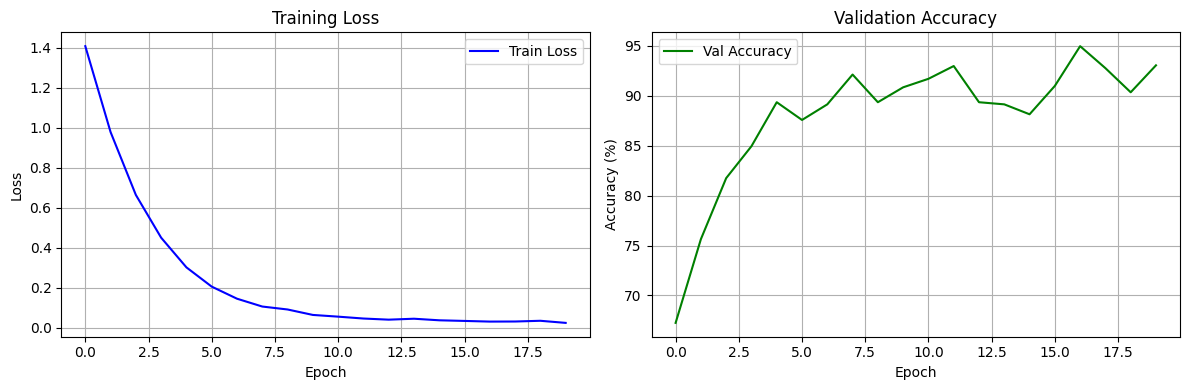

In [ ]:
# Plot training history
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Loss plot
ax1.plot(losses, 'b-', label='Train Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss')
ax1.grid(True)
ax1.legend()

# Accuracy plot
ax2.plot(accuracies, 'g-', label='Val Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Validation Accuracy')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

# Ensemble (LSTM + Transformers)

In [ ]:
# Updated Ensemble Predictor untuk Simplified Transformer
import torch
import numpy as np
import tensorflow as tf

class EnsemblePredictor:
    def __init__(self, lstm_model, transformer_model, tokenizer, label_encoder):  # GANTI idx2label jadi label_encoder
        self.lstm_model = lstm_model
        self.transformer_model = transformer_model
        self.tokenizer = tokenizer
        self.le = label_encoder  # GANTI dari idx2label ke label_encoder
        # Ensure transformer model is in eval mode
        self.transformer_model.eval()
        # Get device from transformer model
        self.device = next(transformer_model.parameters()).device

    def predict(self, text, weights=[0.4, 0.6]):
        """
        Ensemble prediction with weighted average
        weights: [lstm_weight, transformer_weight]
        """
        # LSTM prediction
        lstm_logits = self.lstm_model.predict(tf.constant([text]), verbose=0)
        lstm_probs = tf.nn.softmax(lstm_logits[0]).numpy()

        # Transformer prediction (simplified version)
        # Tokenize
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=32,
            return_tensors='pt'
        )

        # Move to device
        input_ids = encoding['input_ids'].to(self.device)
        attention_mask = encoding['attention_mask'].to(self.device)

        # Get prediction
        with torch.no_grad():
            outputs = self.transformer_model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            trans_logits = outputs.logits
            trans_probs = torch.nn.functional.softmax(trans_logits, dim=-1)
            trans_probs = trans_probs[0].cpu().numpy()

        # Weighted ensemble
        ensemble_probs = (weights[0] * lstm_probs + weights[1] * trans_probs)
        pred_idx = np.argmax(ensemble_probs)
        confidence = ensemble_probs[pred_idx]

        # Get individual predictions
        lstm_pred_idx = np.argmax(lstm_probs)
        trans_pred_idx = np.argmax(trans_probs)

        # GANTI semua self.idx2label dengan self.le.inverse_transform
        return self.le.inverse_transform([pred_idx])[0], confidence, {
            'lstm_pred': self.le.inverse_transform([lstm_pred_idx])[0],
            'trans_pred': self.le.inverse_transform([trans_pred_idx])[0],
            'lstm_conf': float(lstm_probs[lstm_pred_idx]),
            'trans_conf': float(trans_probs[trans_pred_idx])
        }

# Create ensemble predictor (simplified version)
print("Creating ensemble predictor...")
ensemble = EnsemblePredictor(
    lstm_model=model,
    transformer_model=model_transformer,
    tokenizer=tokenizer,
    label_encoder=le  # Sekarang parameter name sudah match
)

Creating ensemble predictor...


In [ ]:
# Test items
test_items = [
    "Nasi Goreng Spesial",
    "AQUA 600ml",
    "Pulpen Pilot",
    "Go-Jek fee",
    "Spotify Premium",
    "Panadol Extra",
    "Charger iPhone",
    "Kaos Uniqlo"
]

# Test ensemble predictions
print("\n" + "="*70)
print("ENSEMBLE PREDICTIONS (LSTM + IndoBERT)")
print("="*70)

for item in test_items:
    try:
        category, conf, details = ensemble.predict(item)
        print(f"\n'{item}':")
        print(f"  Ensemble → {category} (confidence: {conf:.1%})")
        print(f"  LSTM     → {details['lstm_pred']} ({details['lstm_conf']:.1%})")
        print(f"  IndoBERT → {details['trans_pred']} ({details['trans_conf']:.1%})")

        # Show agreement/disagreement
        if details['lstm_pred'] == details['trans_pred']:
            print(f"  Status   → ✓ Models agree")
        else:
            print(f"  Status   → ⚠ Models disagree")
    except Exception as e:
        print(f"\nError predicting '{item}': {str(e)}")


ENSEMBLE PREDICTIONS (LSTM + IndoBERT)

'Nasi Goreng Spesial':
  Ensemble → makanan (confidence: 70.1%)
  LSTM     → makanan (25.4%)
  IndoBERT → makanan (100.0%)
  Status   → ✓ Models agree

'AQUA 600ml':
  Ensemble → minuman (confidence: 70.1%)
  LSTM     → minuman (25.4%)
  IndoBERT → minuman (100.0%)
  Status   → ✓ Models agree

'Pulpen Pilot':
  Ensemble → lain-lain (confidence: 43.5%)
  LSTM     → lain-lain (14.4%)
  IndoBERT → lain-lain (63.0%)
  Status   → ✓ Models agree

'Go-Jek fee':
  Ensemble → minuman (confidence: 61.1%)
  LSTM     → lain-lain (14.4%)
  IndoBERT → minuman (93.5%)
  Status   → ⚠ Models disagree

'Spotify Premium':
  Ensemble → makanan (confidence: 69.8%)
  LSTM     → makanan (25.4%)
  IndoBERT → makanan (99.5%)
  Status   → ✓ Models agree

'Panadol Extra':
  Ensemble → lain-lain (confidence: 69.6%)
  LSTM     → lain-lain (24.0%)
  IndoBERT → lain-lain (100.0%)
  Status   → ✓ Models agree

'Charger iPhone':
  Ensemble → lain-lain (confidence: 49.3%)
  LSTM 

# Evaluation

Evaluating all models on validation set...
Total validation samples: 1408


Predicting: 100%|██████████| 1408/1408 [06:25<00:00,  3.66it/s]



=== Model Accuracies ===
LSTM:        0.856
Transformer: 0.950
Ensemble:    0.950

=== LSTM Model ===
              precision    recall  f1-score   support

         atk       1.00      0.89      0.94        19
  elektronik       1.00      0.55      0.71        22
     fashion       1.00      0.67      0.80        24
     hiburan       0.00      0.00      0.00         3
   kesehatan       1.00      0.65      0.79        26
   lain-lain       0.78      0.98      0.87       681
     makanan       0.96      0.75      0.84       347
     minuman       0.97      0.78      0.86       273
   transport       0.70      0.54      0.61        13

    accuracy                           0.86      1408
   macro avg       0.82      0.64      0.71      1408
weighted avg       0.88      0.86      0.85      1408


=== Transformer Model ===
              precision    recall  f1-score   support

         atk       0.95      1.00      0.97        19
  elektronik       0.88      0.95      0.91        22
  

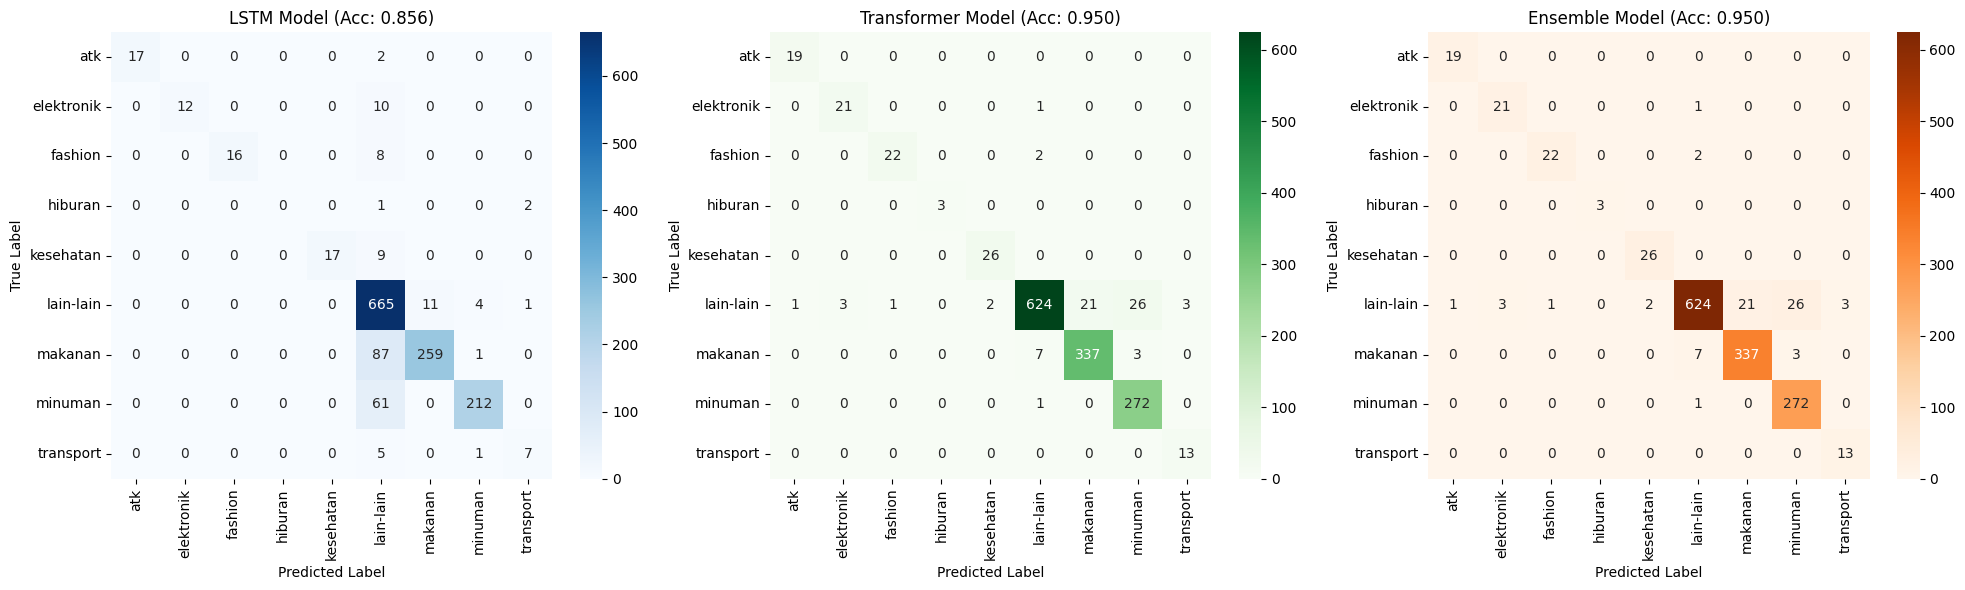

In [ ]:
# Comprehensive evaluation on validation set
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# Fungsi predict yang disesuaikan untuk simplified transformer
def predict_transformer_simple(text, model, tokenizer):
    device = next(model.parameters()).device
    model.eval()

    encoding = tokenizer(
        text,
        truncation=True,
        padding='max_length',
        max_length=32,
        return_tensors='pt'
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.nn.functional.softmax(logits, dim=-1)

    pred_idx = torch.argmax(probs, dim=-1).cpu().numpy()[0]
    confidence = probs[0][pred_idx].cpu().numpy()

    return le.inverse_transform([pred_idx])[0], confidence

# Get all predictions
val_texts = val_df['item'].tolist()
val_true = val_df['label'].tolist()

lstm_preds = []
trans_preds = []
ensemble_preds = []

print("Evaluating all models on validation set...")
print(f"Total validation samples: {len(val_texts)}")

# Use tqdm for progress bar
for text in tqdm(val_texts, desc="Predicting"):
    try:
        # LSTM prediction
        lstm_pred, _ = predict_category(text)
        lstm_preds.append(le.transform([lstm_pred])[0])

        # Transformer prediction (using simplified version)
        trans_pred, _ = predict_transformer_simple(text, model_transformer, tokenizer)
        trans_preds.append(le.transform([trans_pred])[0])

        # Ensemble prediction
        ens_pred, _, _ = ensemble.predict(text)
        ensemble_preds.append(le.transform([ens_pred])[0])

    except Exception as e:
        # Handle any errors by using the most common class
        print(f"\nError processing '{text}': {str(e)}")
        # Use majority class as fallback
        majority_class = max(set(val_true), key=val_true.count)
        lstm_preds.append(majority_class)
        trans_preds.append(majority_class)
        ensemble_preds.append(majority_class)

# Calculate accuracies
from sklearn.metrics import accuracy_score

lstm_acc = accuracy_score(val_true, lstm_preds)
trans_acc = accuracy_score(val_true, trans_preds)
ensemble_acc = accuracy_score(val_true, ensemble_preds)

print(f"\n=== Model Accuracies ===")
print(f"LSTM:        {lstm_acc:.3f}")
print(f"Transformer: {trans_acc:.3f}")
print(f"Ensemble:    {ensemble_acc:.3f}")

# Classification reports
print("\n=== LSTM Model ===")
print(classification_report(val_true, lstm_preds,
                          target_names=le.classes_,
                          zero_division=0))

print("\n=== Transformer Model ===")
print(classification_report(val_true, trans_preds,
                          target_names=le.classes_,
                          zero_division=0))

print("\n=== Ensemble Model ===")
print(classification_report(val_true, ensemble_preds,
                          target_names=le.classes_,
                          zero_division=0))

# Confusion matrices - side by side comparison
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# LSTM confusion matrix
cm_lstm = confusion_matrix(val_true, lstm_preds)
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_,
            ax=axes[0])
axes[0].set_title(f'LSTM Model (Acc: {lstm_acc:.3f})')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# Transformer confusion matrix
cm_trans = confusion_matrix(val_true, trans_preds)
sns.heatmap(cm_trans, annot=True, fmt='d', cmap='Greens',
            xticklabels=le.classes_,
            yticklabels=le.classes_,
            ax=axes[1])
axes[1].set_title(f'Transformer Model (Acc: {trans_acc:.3f})')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

# Ensemble confusion matrix
cm_ensemble = confusion_matrix(val_true, ensemble_preds)
sns.heatmap(cm_ensemble, annot=True, fmt='d', cmap='Oranges',
            xticklabels=le.classes_,
            yticklabels=le.classes_,
            ax=axes[2])
axes[2].set_title(f'Ensemble Model (Acc: {ensemble_acc:.3f})')
axes[2].set_ylabel('True Label')
axes[2].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

In [ ]:
import joblib
joblib.dump(le, "label_encoder.pkl")

['label_encoder.pkl']